In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from minisom import MiniSom

import numpy as np
import scipy.io as scipio

from timeit import default_timer as timer
import time as tm

import seaborn as sns
import pandas as pd

import itertools

%matplotlib inline

# %load_ext autoreload

%run minisom-master/minisom.py

In [2]:
# load needed files
input_npz = np.load('../Synthetic Model/input_fields.npz')
output_smooth_npz = np.load('../Synthetic Model/output_fields_smooth.npz')
output_npz = np.load('../Synthetic Model/output_fields.npz')

In [3]:
def check_inf_nan(in_data):
    
    #display NaN index
    nan_pos = np.argwhere(np.isnan(in_data))
    print("Index with NaN:\n", nan_pos)

    #display inf index
    inf_pos = np.argwhere(np.isinf(in_data))
    print("Index with inf:\n", inf_pos)
        
def replace_inf_nan(in_data, re_inf=9999):
    print("Will replace inf with", re_inf)
    nan_pos = np.argwhere(np.isnan(in_data))
    inf_pos = np.argwhere(np.isinf(in_data))
    
    #replace nan with number
    in_data = np.nan_to_num(in_data)

    #replace inf with number
    in_data[inf_pos[:,0], inf_pos[:,1]] = re_inf
    return in_data, inf_pos

def remove_vpvs(in_data):
    #remove vp/vs from the data to test
    in_data = np.delete(in_data, 4, axis=1)

    print(data.shape)
    return in_data

def normalize_old(in_data):
    norm_data = np.apply_along_axis(lambda x: x/np.linalg.norm(in_data), 1, in_data)
    return norm_data

def normalize(in_data, mean, std):
    norm_data = in_data - mean
    norm_data /= std
    return norm_data

def compute_dim(num_sample):
    dim = 5 * np.sqrt(num_sample)
    dim = np.int(np.sqrt(dim))
    if dim < 10: return 10
    else: return dim
    
def plot_hist(in_data):
    # explore the data
    df = pd.DataFrame(in_data,       # values
                      columns=titles[:-2]) # column name
    
    # Plot histogram of each graph
    fig, ax = plt.subplots(ncols=6, nrows=10, figsize=(20,30))
    fig.tight_layout()
    # Plot histogram of each graph
    for i,ii in zip([1,2,3,4,5,6],range(6)):
        print("Plotting the histogram", titles[i], "of each class.")
        df.hist(column=titles[i], by=titles[0], figsize=(4,20), ax=ax[:,ii]) 
        
    return df.describe()

In [4]:
#function to convert npz to 3d numpy array.

# def convTo3dnp:

titles = output_npz.files
val = input_npz['classes']
val = np.reshape(val, val.shape[0] * val.shape[1])

print("Class number")
print(np.shape(val), np.nanmin(val), np.nanmax(val))
data = []
data.append(val)
for key in output_npz.files[:-2]:
    val = output_npz[key]
    print(key)
    print(val.shape, np.nanmin(val), np.nanmax(val))
    val = np.reshape(val, val.shape[0] * val.shape[1])
    data.append(val)

data = np.transpose(np.array(data))
print("\nAggregated shape:", data.shape)
init_data = np.array(data)

Class number
(24000,) 0 9
vp
(100, 240) 1500.0 6839.872834598128
vs
(100, 240) 0.0 3593.8244297758774
dn
(100, 240) 1000.0 2953.6736203709856
vpvs
(100, 240) 1.6846551790318647 inf
qp
(100, 240) 21.287755021839683 1000.0
qs
(100, 240) 5.745752745694737 1000.0

Aggregated shape: (24000, 7)


In [5]:
check_inf_nan(init_data)
print("---")
# re_inf = 1e38
re_inf = -9999
data, inf_pos = replace_inf_nan(init_data, re_inf=re_inf)
check_inf_nan(data)


Index with NaN:
 []
Index with inf:
 [[   0    4]
 [   1    4]
 [   2    4]
 ...
 [3597    4]
 [3598    4]
 [3599    4]]
---
Will replace inf with -9999
Index with NaN:
 []
Index with inf:
 []


In [6]:
def som_assemble(in_data, seed, dim, lr=0.5, sigma=2.5):
    # Initialization som and weights
    num_features = np.shape(in_data)[1]
    som = MiniSom(dim, dim, num_features, sigma=sigma, learning_rate=lr, 
                  neighborhood_function='gaussian', random_seed=seed)

    som.pca_weights_init(in_data)
    
    return som

def plot_som(som, norm_data, label, save=False, model_name='temp'):
    plt.figure(figsize=(9,7))
    # Plotting the response for each litho-class
    plt.pcolor(som.distance_map().T, cmap='bone_r')  
    # plotting the distance map as background
    plt.colorbar()

    for t, xx in zip(label, norm_data):
        w = som.winner(xx)  # getting the winner
        # palce a marker on the winning position for the sample xx
        plt.text(w[0]+.5, w[1]+.5, str(t),
                 color=plt.cm.rainbow(t/10.))
        
    plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
    if(save):
        save_dir = 'SOMs_results/' + model_name + '_plot.png'
        plt.savefig(save_dir)
        print('Plot saved at:', save_dir)
#     plt.show()
    
def write_param(model_name, dim, it, lr, re_inf, et, sigma):
    params = str(model_name) + '\n---' + \
             '\nseed,' + str(seed) + \
             '\ndim,' + str(dim) + \
             '\niterations,' + str(it) + \
             '\nlearning rate,' + str(lr) + \
             '\nsigma,' + str(sigma) + \
             '\ninf,' + str(re_inf) + \
             '\nelapsed time,' + str(et) + '\n\n'
    return params

def save_som(param_vals, som, report, c_matrix, model_name, grid=False, rand=False):
    #save report to file
    fdir, mode = '', ''
    if(grid):
        fdir = 'SOMs_results/grid_search/gridsearch_report.csv'
        mode = 'a+'
    elif(rand):
        fdir = 'SOMs_results/random_search/randomsearch_report.csv'
        mode = 'a+'
    else:
        fdir = 'SOMs_results/' + model_name + '_report.csv'
        mode = 'w'
    f1 = open(fdir, mode) 

    f1.write(param_vals) 
    f1.write(report) 
    f1.write('\nConfusion Matrix\n') 
    np.savetxt(f1, c_matrix,fmt='%i', delimiter=",")
    f1.write('\n\n--------------------\n\n')
    f1.close() #to change file access modes  
    print('Report saved at:', fdir)
    
    #pickle the model
    fdir = 'SOMs_results/' + model_name + '_model.p'
    with open(fdir, 'wb') as outfile:
        pickle.dump(som, outfile)
        
    print('Model saved at:', fdir)

Plotting the histogram Vp (m/s) of each class.
Plotting the histogram Vs (m/s) of each class.
Plotting the histogram Density (kg/m$^3$) of each class.
Plotting the histogram Vp/Vs of each class.
Plotting the histogram Qp of each class.
Plotting the histogram Qs of each class.


,Class,Vp (m/s),Vs (m/s),Density (kg/m$^3$),Vp/Vs,Qp,Qs
count,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000
mean,5.781542,4992.238141,2568.355191,2507.922763,1.572465e+06,362.260448,200.312265
std,2.733977,1514.954805,1088.173414,559.282839,1.549927e+07,272.012099,283.128665
min,0.000000,1500.000000,0.000000,1000.000000,-9.999000e+03,21.287755,5.745753
25%,4.000000,4494.293703,2260.791673,2552.433353,1.732286e+00,135.393450,52.494650
50%,7.000000,5462.577949,3056.956496,2725.016273,1.806479e+00,320.931714,122.304746
75%,8.000000,6053.742247,3319.861911,2791.436386,1.911542e+00,455.174135,164.067135
max,9.000000,6839.872835,3593.824430,2953.673620,2.259288e+08,1000.000000,1000.000000


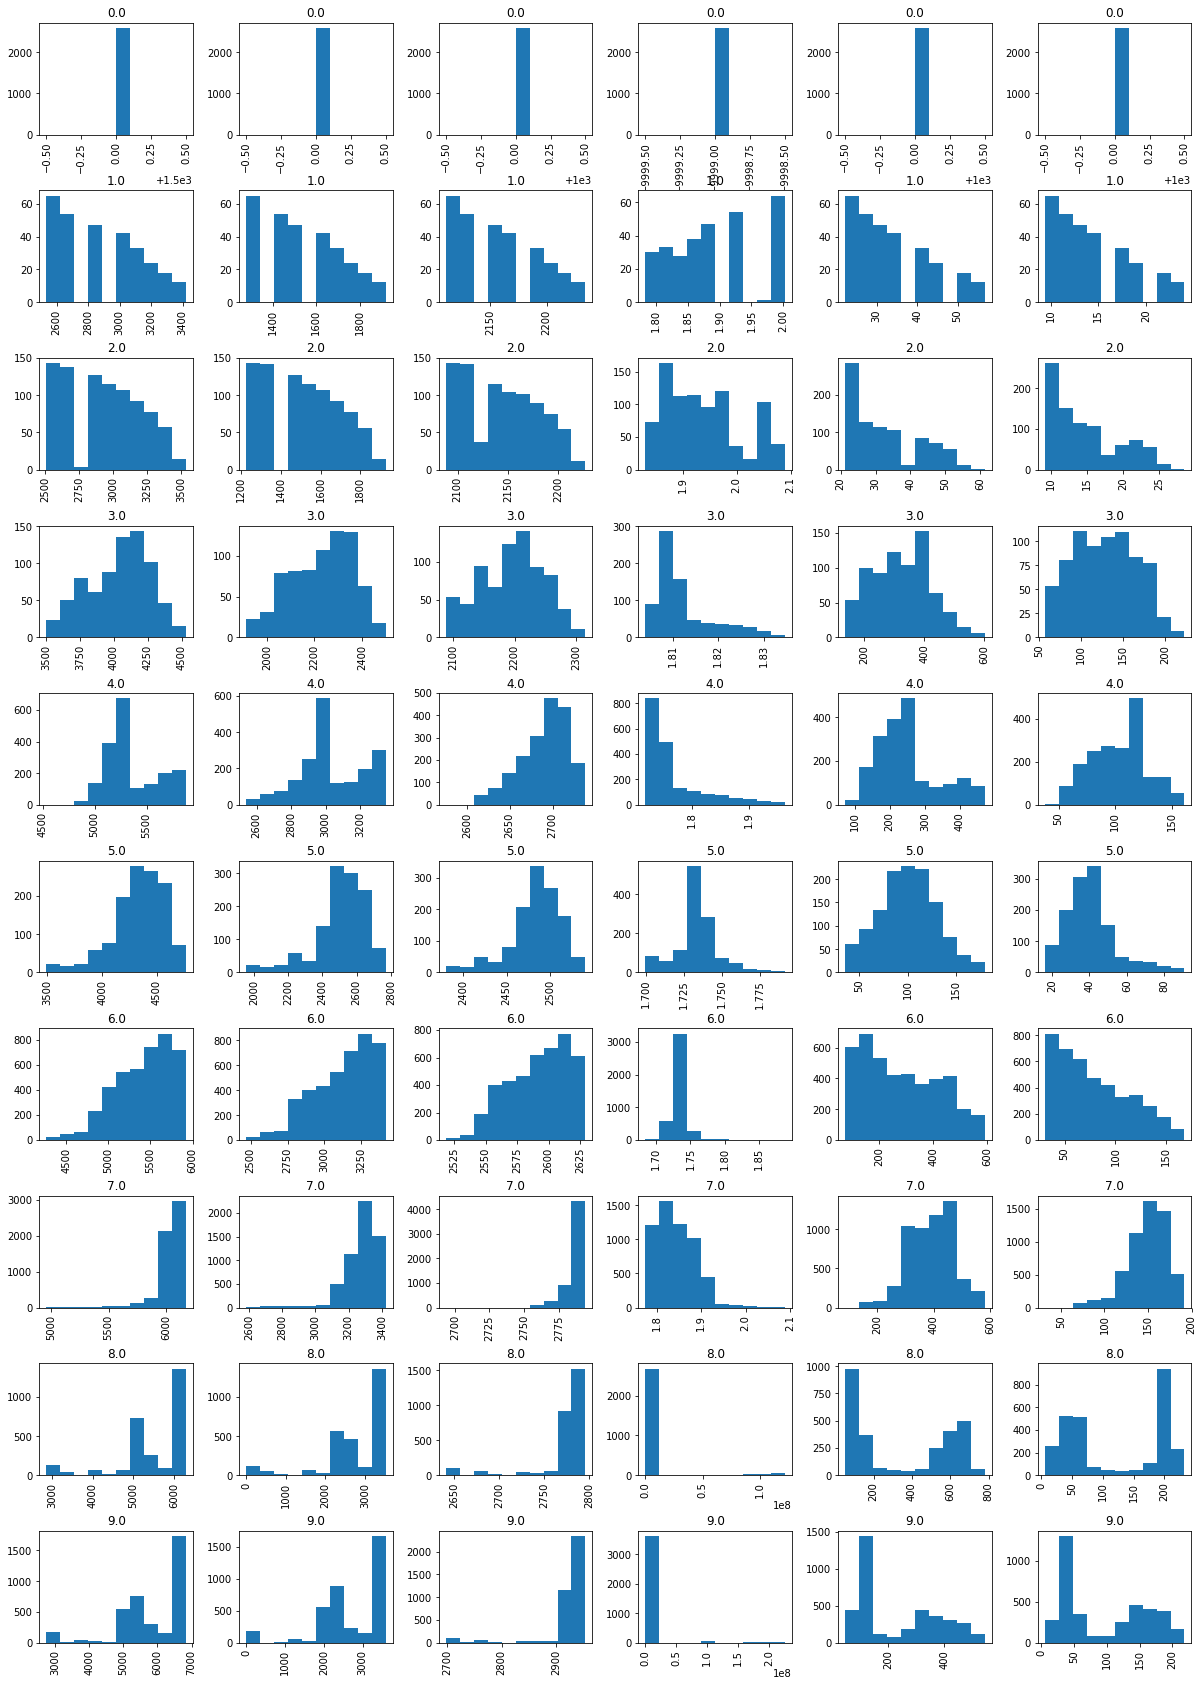

In [7]:
titles = ['Class', 'Vp (m/s)', 'Vs (m/s)', 'Density (kg/m$^3$)', 'Vp/Vs', 'Qp', 'Qs', 'X', 'Z']
plot_hist(data)
# plot_hist(normalize(data))

In [21]:
seed = 10

# define data labels
label = (data[:,0]).astype(int)

## data normalization
# norm_data = normalize(data[:,1:])
mean = data[:,1:].mean()
std = data[:,1:].std()
norm_data = normalize(data[:,1:], mean, std)
X_train, X_test, y_train, y_test = train_test_split(norm_data, label, random_state=seed)
print(norm_data.shape)

(24000, 6)


saved file: results/fulltest_20190703-221703
dim: 32 iter: 5000 lr: 0.5 sigma: 2

---------------
elapsed time: 6.949534418992698
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000       631
          1     0.8710    0.3649    0.5143        74
          2     0.8266    0.9825    0.8978       228
          3     1.0000    1.0000    1.0000       191
          4     0.9873    0.9936    0.9904       469
          5     0.9397    0.9673    0.9533       306
          6     0.9895    0.9738    0.9816      1069
          7     0.9501    0.9909    0.9701      1423
          8     0.9742    0.8947    0.9327       674
          9     0.9946    0.9936    0.9941       935

avg / total     0.9703    0.9697    0.9681      6000

[[ 631    0    0    0    0    0    0    0    0    0]
 [   0   27   47    0    0    0    0    0    0    0]
 [   0    4  224    0    0    0    0    0    0    0]
 [   0    0    0  191    0    0    0    0    0    0]
 [   0    0    0   

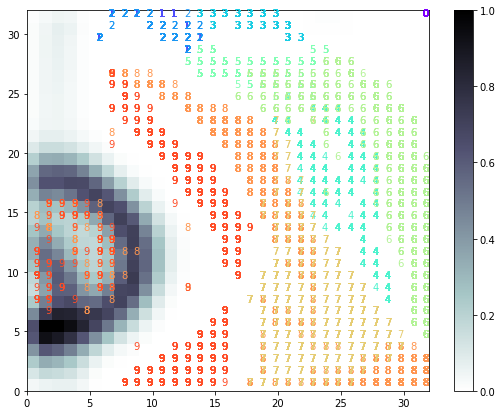

In [17]:
### test SOMs
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 32
iter_cnt = 5000
lr = 0.5
sigma = 2

# define model name for saving
model_name = 'results/fulltest_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(X_train, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

som.labels_map(X_train, y_train)
y_pred = np.array(som.classify(X_test))

report = classification_report(y_test, y_pred, digits=4)
print(report)
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
save_som(param_vals, som, report, c_matrix, model_name)
plot_som(som, norm_data, label, model_name=model_name, save=True)

In [22]:
y_pred2 = np.array(som.classify(X_train))
accuracy_score(y_train, y_pred2)

0.9683888888888889

In [23]:
accuracy_score(y_test, y_pred)

0.14966666666666667

In [ ]:
## parameter tuning
# grid search
def grid_search_som(init_num):
    
    dims = [-5, 0, 5, 10]
    dims += np.array(compute_dim(norm_data.shape[0]))
    idx = np.argwhere(dims<=0)
    if(idx.size!=0):
        dims = dims[idx[-1][0]:]
#    dim = [22, 27, 32, 37]
    iter_cnts = [2000, 4000, 5000, 6000]
    lr = [0.25, 0.5, 0.75]#, 1e-3, 1e-4]
    sigma = [1, 2, 2.5, 3, 4]

# # small grid test
#     dims = [5]
#     iter_cnts = [10, 20]
#     lr = [0.75]
#     sigma = [1]
    
    test_num = init_num
    
    hyperpara = [dims, iter_cnts, lr, sigma]
    hyperpara_perm = list(itertools.product(*hyperpara))
    
    best_acc = 0
    best_comb = []
    best_model = ''
    
    for comb in hyperpara_perm:
        print(comb[0]," ",comb[1], " ", comb[2], " ", comb[3])

        test_num += 1
        model_name = 'grid_search/grid_' + str(test_num)
        
        som = som_assemble(norm_data, seed, comb[0], lr=comb[2], sigma=comb[3])
        
        start = timer()
        som.train_random(X_train, comb[1], verbose=False)
        end = timer()
        elapsed_time = end - start
        
        som.labels_map(X_train, y_train)
        y_pred = np.array(som.classify(X_test))
        curr_acc = accuracy_score(y_test, y_pred)
        
        if(best_acc < curr_acc):
            best_acc = curr_acc
            best_comb = comb
            best_model = model_name
            print('current best model:', best_model)
            print('current best comb:', best_comb)
            print('current best acc:', best_acc)
            
        #save the current model
#         plot_som(som, norm_data, label, save=True, model_name=model_name)
        report = classification_report(y_test, y_pred, digits=4)
        c_matrix = confusion_matrix(y_test, y_pred)

        param_vals = write_param(model_name=model_name, dim=comb[0], it=comb[1], lr=comb[2], re_inf=re_inf, et=elapsed_time, sigma=comb[3])

        save_som(param_vals, som=som, report=report, c_matrix=c_matrix, model_name=model_name, grid=True)
    print('Best model found:', best_model)
    print('Best comb found:', best_comb)
    print('Best acc found:', best_acc)

    return best_comb

In [ ]:
# run gridsearch to find best result
# best_comb = grid_search_som(0)
# print(best_comb)
# dim, iter_cnt, lr, sigma = best_comb

In [26]:
# test load model
filename = 'SOMs_results/results/fulltest_20190703-221446_model.p'
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.labels_map(X_train, y_train)
y_pred = np.array(loaded_model.classify(X_test))
report = classification_report(y_test, y_pred, digits=4)
print(report)

             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000       680
          1     1.0000    0.7260    0.8413        73
          2     0.9184    1.0000    0.9574       225
          3     1.0000    1.0000    1.0000       193
          4     0.9876    0.9979    0.9927       480
          5     0.9474    0.9931    0.9697       290
          6     0.9972    0.9787    0.9879      1080
          7     0.9467    0.9790    0.9626      1379
          8     0.9226    0.8791    0.9003       637
          9     0.9905    0.9740    0.9822       963

avg / total     0.9709    0.9705    0.9702      6000



In [27]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

[[ 680    0    0    0    0    0    0    0    0    0]
 [   0   53   20    0    0    0    0    0    0    0]
 [   0    0  225    0    0    0    0    0    0    0]
 [   0    0    0  193    0    0    0    0    0    0]
 [   0    0    0    0  479    0    1    0    0    0]
 [   0    0    0    0    0  288    2    0    0    0]
 [   0    0    0    0    6   16 1057    1    0    0]
 [   0    0    0    0    0    0    0 1350   29    0]
 [   0    0    0    0    0    0    0   68  560    9]
 [   0    0    0    0    0    0    0    7   18  938]]


In [30]:
y_pred2 = np.array(loaded_model.classify(X_train))
report = classification_report(y_train, y_pred2, digits=4)
c_matrix2 = confusion_matrix(y_train, y_pred2)
print(c_matrix2)

[[1903    0    0    0    0    0    0    0    0    0]
 [   0  147   75    0    0    0    0    0    0    0]
 [   0    5  643    0    0    2    0    0    0    0]
 [   0    0    0  552    0    0    0    0    0    0]
 [   0    0    0    0 1404    1    0    0    0    0]
 [   0    0    0    0    0  947    7    0    0    0]
 [   0    0    0    0   15   52 3071    0    0    0]
 [   0    0    0    0    1    0    1 4168   57    0]
 [   0    0    0    0    0    0    0  189 1943    5]
 [   0    0    0    0    0    0    0    0   28 2784]]


In [43]:
def gen_param_grid(ideal_dim):
#     min_dim = ideal_dim - 5 if ideal_dim - 5 > 10 else 10
#     max_dim = ideal_dim * 2 if ideal_dim * 2 > 10 else 20
    min_dim, max_dim = 30, 35
    param_grid = {
        'dim': list(range(min_dim, max_dim+1)),
        'iter_cnt': list(range(4000, 5001, 200)),
        'learning_rate': list(np.logspace(np.log10(0.5), np.log10(0.75), base = 10, num = 100)),
        'sigma': list(np.linspace(2, 2.5, num=30)),
    }
    return param_grid

# random search
def random_search_som(init_num, param_grid, max_evals=10):
    
    test_num = init_num
    
    best_acc = 0
    best_comb = []
    best_model = ''
    random.seed(seed)
    
    for i in range(max_evals):
        
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        comb = list(random_params.values())
        
        print(comb[0]," ",comb[1], " ", comb[2], " ", comb[3])

        test_num += 1
        model_name = 'random_search/random_' + str(test_num)
        
        som = som_assemble(norm_data, seed, comb[0], lr=comb[2], sigma=comb[3])
        
        start = timer()
        som.train_random(X_train, comb[1], verbose=False)
        end = timer()
        elapsed_time = end - start
        
        som.labels_map(X_train, y_train)
        y_pred = np.array(som.classify(X_test))
        curr_acc = accuracy_score(y_test, y_pred)
        
        if(best_acc < curr_acc):
            best_acc = curr_acc
            best_comb = comb
            best_model = model_name
            print('current best model:', best_model)
            print('current best comb:', best_comb)
            print('current best acc:', best_acc)
            
        #save the current model
#         plot_som(som, norm_data, label, save=True, model_name=model_name)
        report = classification_report(y_test, y_pred, digits=4)
        c_matrix = confusion_matrix(y_test, y_pred)

        param_vals = write_param(model_name=model_name, dim=comb[0], it=comb[1], lr=comb[2], re_inf=re_inf, et=elapsed_time, sigma=comb[3])

        save_som(param_vals, som=som, report=report, c_matrix=c_matrix, model_name=model_name, rand=True)
        
    print('Best model found:', best_model)
    print('Best comb found:', best_comb)
    print('Best acc found:', best_acc)

    return best_comb, best_acc
        


In [44]:
import random

ideal_dim = compute_dim(norm_data.shape[0])
param_grid = gen_param_grid(ideal_dim)
# print(param_grid)
best_comb, best_acc = random_search_som(0, param_grid, max_evals=50)

34   4000   0.6237632470919713   2.2586206896551726
current best model: random_search/random_1
current best comb: [34, 4000, 0.6237632470919713, 2.2586206896551726]
current best acc: 0.968
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_1_model.p
34   4000   0.5561810575911957   2.2413793103448274
current best model: random_search/random_2
current best comb: [34, 4000, 0.5561810575911957, 2.2413793103448274]
current best acc: 0.9725
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_2_model.p
33   4400   0.702428412491486   2.4310344827586206
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_3_model.p
31   4000   0.6551853485522241   2.2586206896551726
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_4_model.p
32   4

Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_43_model.p
33   4600   0.5360532054354206   2.2413793103448274
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_44_model.p
33   4800   0.6314745916857393   2.1724137931034484
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_45_model.p
35   4400   0.7199034710271105   2.2413793103448274
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_46_model.p
33   4400   0.702428412491486   2.2758620689655173
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_47_model.p
34   4200   0.734797661448601   2.1206896551724137
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/

In [45]:
 # test load model
filename = 'SOMs_results/random_search/random_42_model.p'
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.labels_map(X_train, y_train)
y_pred = np.array(loaded_model.classify(X_test))
report = classification_report(y_test, y_pred, digits=4)
print(report)

             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000       680
          1     1.0000    0.7260    0.8413        73
          2     0.9184    1.0000    0.9574       225
          3     1.0000    1.0000    1.0000       193
          4     0.9917    0.9958    0.9938       480
          5     0.9600    0.9931    0.9763       290
          6     0.9981    0.9815    0.9897      1080
          7     0.9488    0.9935    0.9706      1379
          8     0.9561    0.8885    0.9211       637
          9     0.9916    0.9772    0.9843       963

avg / total     0.9762    0.9757    0.9753      6000



In [46]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

[[ 680    0    0    0    0    0    0    0    0    0]
 [   0   53   20    0    0    0    0    0    0    0]
 [   0    0  225    0    0    0    0    0    0    0]
 [   0    0    0  193    0    0    0    0    0    0]
 [   0    0    0    0  478    0    0    2    0    0]
 [   0    0    0    0    0  288    2    0    0    0]
 [   0    0    0    0    3   12 1060    5    0    0]
 [   0    0    0    0    1    0    0 1370    8    0]
 [   0    0    0    0    0    0    0   63  566    8]
 [   0    0    0    0    0    0    0    4   18  941]]


In [47]:
y_pred2 = np.array(loaded_model.classify(X_train))
report = classification_report(y_train, y_pred2, digits=4)
c_matrix2 = confusion_matrix(y_train, y_pred2)
print(c_matrix2)

[[1903    0    0    0    0    0    0    0    0    0]
 [   0  147   75    0    0    0    0    0    0    0]
 [   0    0  650    0    0    0    0    0    0    0]
 [   0    0    0  552    0    0    0    0    0    0]
 [   0    0    0    0 1399    1    4    1    0    0]
 [   0    0    0    0    0  949    5    0    0    0]
 [   0    0    0    0   11   58 3069    0    0    0]
 [   0    0    0    0    3    0    1 4173   50    0]
 [   0    0    0    0    0    0    0  176 1946   15]
 [   0    0    0    0    0    0    0    0   23 2789]]


Plot saved at: SOMs_results/random_42__plot.png


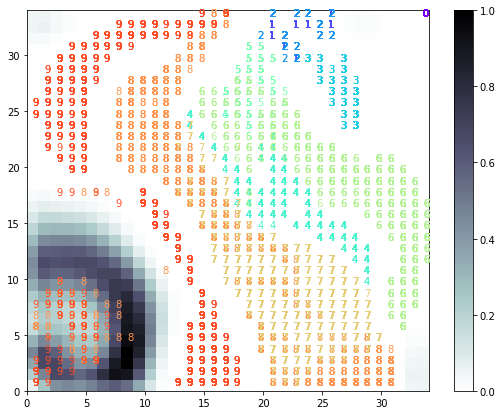

In [49]:
plot_som(loaded_model, norm_data, label, model_name="random_42", save=True)

In [50]:
train_acc = accuracy_score(y_train, y_pred2)
test_acc = accuracy_score(y_test, y_pred)
print(train_acc,'\t', test_acc)

0.9765 	 0.9756666666666667
